<a href="https://colab.research.google.com/github/omarsayed7/Satellite-Segmentation/blob/main/Data_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio && GDAL==3.2.2 && paddleseg && paddlepaddle
!pip install pyshp
#mount google drive
from google.colab import drive 
drive.mount("/content/drive/")

/bin/bash: paddleseg: command not found
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import math, cv2
import os, sys, subprocess
import numpy as np 
from osgeo import gdal, ogr
import matplotlib.pyplot as plt

In [3]:
 OLD_DATASET_PATH = 'drive/MyDrive/graduation-project/output 2019'
 NEW_DATASET_PATH = 'drive/MyDrive/graduation-project/output/'
 LABEL_OUTPUT = 'label.tif'

In [4]:
os.listdir(NEW_DATASET_PATH)

['output2021.tfw',
 'output2021.tif',
 'output2021.tif.ovr',
 'output2021.tif.aux.xml',
 'Export_Output.prj',
 'Export_Output.dbf',
 'Export_Output.sbn',
 'Export_Output.sbx',
 'Export_Output.shx',
 'Export_Output.cpg',
 'Export_Output.shp',
 'Export_Output.shp.DESKTOP-164F5K8.9080.19096.sr.lock']

In [5]:
fn_ras = os.path.join(NEW_DATASET_PATH,'output2021.tif')
fn_vec = os.path.join(NEW_DATASET_PATH,'Export_Output.shp')

In [6]:
driver = ogr.GetDriverByName("ESRI Shapefile")
ras_ds = gdal.Open(fn_ras)
vec_ds = driver.Open(fn_vec, 1)

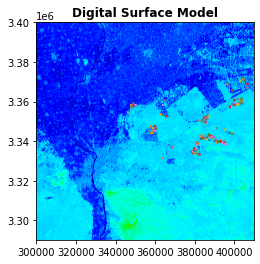

In [7]:
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show 

dsm = rasterio.open(fn_ras)
sf = shp.Reader(fn_vec)

plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
show(dsm, title='Digital Surface Model', cmap='gist_ncar')
plt.show()

In [8]:
print(sf.bbox)

[346219.3853658056, 3331596.7875015475, 406960.95255460445, 3372531.924967841]


In [9]:
lyr = vec_ds.GetLayer()
geot = ras_ds.GetGeoTransform()
proj = ras_ds.GetProjection() # Get the projection from original tiff (fn_ras)

In [10]:
#To get the coordinates of the corners of your geotiff do the following:
width = ras_ds.RasterXSize
height = ras_ds.RasterYSize

minx = geot[0] #lower left x
miny = geot[3] + width*geot[4] + height*geot[5] #lower left y
maxx = geot[0] + width*geot[1] + height*geot[2] #upper right x
maxy = geot[3] #upper right y

minx, miny, maxx, maxy

(300000.0, 3290220.0, 409800.0, 3400020.0)

In [11]:
#https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
import osr
# get CRS from dataset 
crs = osr.SpatialReference()
crs.ImportFromWkt(ras_ds.GetProjectionRef())
# create lat/long crs with WGS84 datum
crsGeo = osr.SpatialReference()
crsGeo.ImportFromEPSG(4326) # 4326 is the EPSG id of lat/long crs 
t = osr.CoordinateTransformation(crs, crsGeo)
(lat, long, z) = t.TransformPoint(minx, miny)
(lat2, long2, z2) = t.TransformPoint(maxx, maxy)
print(lat, long, z)
print(lat2, long2, z2)

30.932223205884945 29.72604902556356 0.0
32.057829637596484 30.729650251360194 0.0


In [12]:
#Create Raster image for Labels
input_shp = ogr.Open(fn_vec)
shp_layer = input_shp.GetLayer()

pixel_size = 20
#To get the coordinates of the corners of your geotiff do the following:
width = ras_ds.RasterXSize
height = ras_ds.RasterYSize

minx = geot[0] #lower left x
miny = geot[3] + width*geot[4] + height*geot[5] #lower left y
maxx = geot[0] + width*geot[1] + height*geot[2] #upper right x
maxy = geot[3] #upper right y

minx, miny, maxx, maxy

ds = gdal.Rasterize(LABEL_OUTPUT, fn_vec, xRes=pixel_size, yRes=pixel_size, 
                    burnValues=255, outputBounds=[minx, miny, maxx, maxy], 
                    outputType=gdal.GDT_Byte)
ds = None

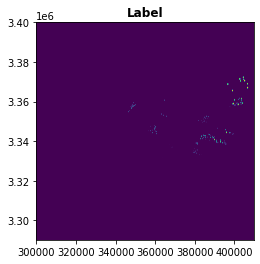

array([  0, 255], dtype=uint8)

In [13]:
import rasterio
from rasterio.plot import show 

label = rasterio.open(LABEL_OUTPUT)
show(label, title='Label')
plt.show()
np.unique(label.read(1))

In [14]:
!gdalinfo /content/drive/MyDrive/graduation-project/output/output2021.tif

Driver: GTiff/GeoTIFF
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining 

In [15]:
!gdalinfo label.tif

Driver: GTiff/GeoTIFF
Files: label.tif
Size is 5490, 5490
Coordinate System is:
PROJCS["WGS 84 / UTM zone 36N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",33],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32636"]]
Origin = (300000.000000000000000,3400020.000000000000000)
Pixel Size = (20.000000000000000,-20.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Stru

In [16]:
#Second - Splitting raster and rasterized files to small tiles 512×512 
#depends on your memory

In [17]:
ds = gdal.Open(fn_ras)
gt = ds.GetGeoTransform()

In [18]:
import math
import os.path as osp
def get_numOf_tiles(source,get_transform,sizeX, sizeY):
    needed_out_x = sizeX
    needed_out_y = sizeY

    xmin = get_transform[0]
    ymax = get_transform[3]
    resx = get_transform[1]
    res_y = get_transform[5]
    resy = abs(res_y)

    xnotround = source.RasterXSize / needed_out_x
    xround = math.ceil(xnotround)
    ynotround = source.RasterYSize / needed_out_y
    yround = math.ceil(ynotround)

    pixtomX = needed_out_x * xround * resx
    pixtomy = needed_out_y * yround * resy

    #size of a single tile
    xsize = pixtomX / xround
    ysize = pixtomy / yround

    #create lists of x and y coordinates
    xsteps = [xmin + xsize * i for i in range(xround + 1)]
    ysteps = [ymax - ysize * i for i in range(yround + 1)]

    return xsteps, ysteps, xround, yround, resx, resy

In [19]:
#set the output path
base_directory = "Dataset"
data_output_directory = os.path.join(base_directory,"images")
label_output_directory = os.path.join(base_directory,"labels")

if not os.path.exists(base_directory):
    os.mkdir(base_directory)

In [20]:
#spliting the source tif file iinto (512,512) small tiles
def split_gtif(output_directory, source_tif, tile_name, sizeX, sizeY):
    source = gdal.Open(source_tif)
    gt = source.GetGeoTransform()
    xsteps, ysteps, xround, yround, resx, resy = get_numOf_tiles(source, gt, sizeX,sizeY)

    for i in range(xround):
        for j in range(yround):
            xmin = xsteps[i]
            xmax = xsteps[i + 1]
            ymax = ysteps[j]
            ymin = ysteps[j + 1]
            # gdal translate to subset the input raster
            if not os.path.exists(output_directory):
                os.mkdir(output_directory)

            output_path = osp.join(output_directory,(str(tile_name) + "-" + str(j) + "-" + str(i) + "." + "jpg"))
            if tile_name == "mask" :
                bandList = None
            else:
                bandList =(4,3,2)
            
            try:
                gdal.Translate(output_path, 
                            source,bandList=bandList, # RGB Bands
                            projWin=(abs(xmin), abs(ymax), abs(xmax), abs(ymin)),
                            xRes=resx, 
                            yRes=-resy,
                            format="JPEG", 
                            outputType=gdal.gdalconst.GDT_Byte,
                            scaleParams=[[]])
            except:
                print("Unexpected error color:", sys.exc_info(), gdal.GetLastErrorMsg())
    print("DONE")


In [21]:
split_gtif(data_output_directory,fn_ras,"img", 512, 512)

DONE


In [22]:
split_gtif(label_output_directory,LABEL_OUTPUT,"mask", 512, 512)

DONE


In [23]:
#saving the dataset tiles to drive
!mv Dataset/ /content/drive/MyDrive

In [24]:
#Showing the (512,512,3) RGB tiles 
from google.colab.patches import cv2_imshow

def images_show(images_directory,num_of_images):
    for img in os.listdir(images_directory):
        img_extension = img.split(".")[-1]
        if img_extension == "jpg" and num_of_images > 0:
            num_of_images -= 1 
            image = cv2.imread(os.path.join(images_directory, img), cv2.IMREAD_UNCHANGED)
            plt.imshow(image)
        plt.show()


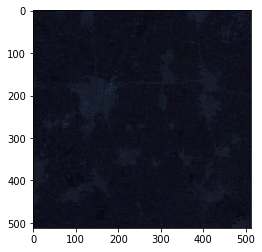

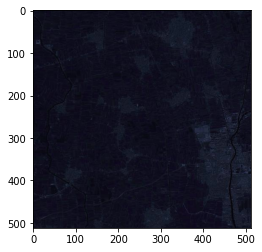

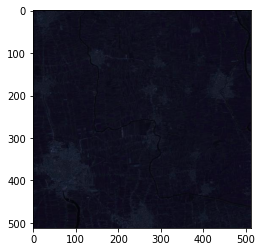

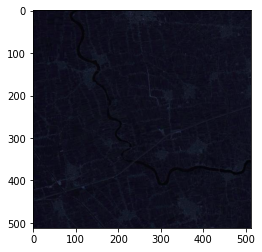

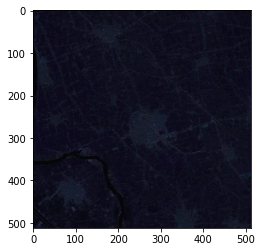

In [25]:
images_show("/content/drive/MyDrive/Dataset/images",5)

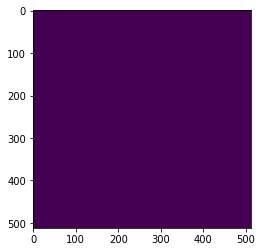

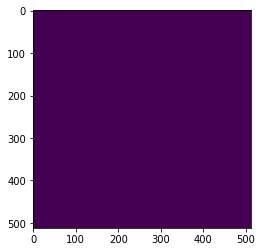

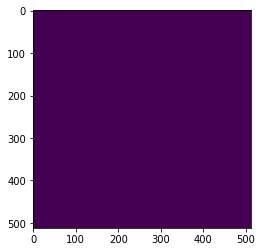

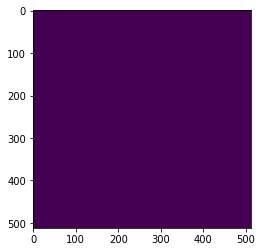

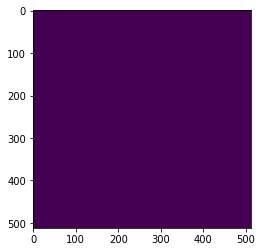

In [26]:
images_show("/content/drive/MyDrive/Dataset/labels",5)